In [1]:
from functools import partial # There are going to be some things we want to initialize lazily to economize on resources and reuse constructor calls.
import torch
# everything will use the same tokenizer
from transformers import AutoTokenizer
mistral = "mistralai/Mistral-7B-v0.1"
tokenizer = AutoTokenizer.from_pretrained(mistral, padding_side = "right")
tokenizer.pad_token = tokenizer.eos_token

In [2]:
## Everything will use the same dataset and dataloaders
repo = "wikimedia/wikipedia"
import datasets
ds = datasets.load_dataset(repo, "20231101.simple")
def quick_estimate_tokens(ds, field="text", chars_per_token=2.7):
    tally = 0
    max_len = 0
    lengths = {}
    for row in ds:
        l = len(row[field])
        tally += l
        lengths[l] = lengths.get(l, 0) + 1
        if l > max_len:
            max_len = l

    print(f'{int(tally):_}')
    print(f'Max length: {max_len}, estimated tokens: {int(max_len / chars_per_token):_}')
    lengths = list(lengths.items())
    lengths.sort(reverse=True)
    return int(tally/chars_per_token), lengths

total, length = quick_estimate_tokens(ds['train'], field="text")
ds = ds["train"].train_test_split(test_size=0.1)

max_tokens = 512
def batch_tokenize(batch):
    return {"input_ids": tokenizer(batch["text"], padding="max_length", truncation=True, max_length=max_tokens).input_ids}

tokenized = ds.map(batch_tokenize, batched=True, batch_size=1000)

from torch.utils.data import DataLoader

tokenized.set_format(type='torch', columns=['input_ids'])

267_477_061
Max length: 236695, estimated tokens: 87_664


Map:   0%|          | 0/217608 [00:00<?, ? examples/s]

Map:   0%|          | 0/24179 [00:00<?, ? examples/s]

In [21]:
%load_ext autoreload
%autoreload 2

batch_size = 32
train_loader = DataLoader(tokenized["train"], batch_size=batch_size, shuffle = True)
eval_loader = DataLoader(tokenized["test"], batch_size=32, shuffle = False)


import sys
path = r'C:\Users\infin\OneDrive\Documents\GitHub\aimodels\projects\tooling'
sys.path.insert(0, path)
from mixers import MixerModel, EmbeddingVectorizer, EmbeddingAndPositionalVectorizer, AttentionMixer, GatedStateMixer, no_activation, LinearAttentionMixer
import torch
from functools import partial
model_dim, layers, heads = 256, 3, 4
max_seq_len = 512 ## !!! Should we factor this out of being a required argument?  Or is it, even, now?

base_model = MixerModel(
    model_size = model_dim,
    num_layers = layers,
    max_seq_len = 512, 
    vectorizer = EmbeddingVectorizer,
    seq_mixer = (AttentionMixer, {"num_heads": heads, "apply_rope": True}),
    tokenizer = tokenizer,
)

test_model = MixerModel(
    model_size = model_dim,
    num_layers = layers,
    max_seq_len = 512,
    vectorizer = EmbeddingVectorizer,
    seq_mixer = (LinearAttentionMixer, {"num_heads": heads, "apply_rope": True, "feature_map": LinearAttentionMixer.taylor_expansion}),
    tokenizer = tokenizer,
)

print(
f"""Base / test model:
{base_model.num_parameters():_} / {test_model.num_parameters():_} parameters;
{base_model.num_parameters(include_embeddings = False):_} / {test_model.num_parameters(include_embeddings=False):_} without embeddings."""
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
note: tying weights
note: tying weights
Base / test model:
10_554_880 / 10_554_880 parameters;
2_362_880 / 2_362_880 without embeddings.


In [14]:
from train import Trainer, SimpleTestCallback, ResidualGatingWarmupCallback, get_warmup_schedule, TimedStoppingCallback, PerplexityStoppingCallback
base_trainer = Trainer(
    base_model,
    train_loader,
    eval_loader = eval_loader,
    device = "cuda",
    tokenizer = tokenizer,
    log_every = 250,
    eval_every = 10_000,
    schedule = get_warmup_schedule(),
    autocast_dtype = torch.bfloat16,
    callbacks = [TimedStoppingCallback(600)]
)
base_trainer.train(2)


Training for 2 epochs starting from epoch 1; 6801 steps per epoch.
Beginning epoch 1
{'mode': 'train', 'epoch': 1, 'step': 250, 'steps': 250, 'seconds': 19.169811964035034, 'total_seconds': 19.169811964035034, 'loss': 8.573249092102051, 'ppl': 5288.28271484375}
{'mode': 'train', 'epoch': 1, 'step': 500, 'steps': 250, 'seconds': 18.491865634918213, 'total_seconds': 37.66167759895325, 'loss': 5.82037721824646, 'ppl': 337.0992431640625}
{'mode': 'train', 'epoch': 1, 'step': 750, 'steps': 250, 'seconds': 18.40096664428711, 'total_seconds': 56.062644243240356, 'loss': 4.985503973007202, 'ppl': 146.2772979736328}
{'mode': 'train', 'epoch': 1, 'step': 1000, 'steps': 250, 'seconds': 18.44843029975891, 'total_seconds': 74.51107454299927, 'loss': 4.5791409282684326, 'ppl': 97.43067932128906}
{'mode': 'train', 'epoch': 1, 'step': 1250, 'steps': 250, 'seconds': 18.46306300163269, 'total_seconds': 92.97413754463196, 'loss': 4.288870355606079, 'ppl': 72.88408660888672}
{'mode': 'train', 'epoch': 1, 

In [22]:
from train import Trainer, SimpleTestCallback, ResidualGatingWarmupCallback, get_warmup_schedule, TimedStoppingCallback, PerplexityStoppingCallback
test_trainer = Trainer(
    test_model,
    train_loader,
    eval_loader = eval_loader,
    device = "cuda",
    tokenizer = tokenizer,
    log_every = 250,
    eval_every = 10_000,
    schedule = get_warmup_schedule(),
    autocast_dtype = torch.bfloat16,
    callbacks = [TimedStoppingCallback(600)]
)
test_trainer.train(2)

Training for 2 epochs starting from epoch 1; 6801 steps per epoch.
Beginning epoch 1
running cleanup routines


AttributeError: 'float' object has no attribute 'to'

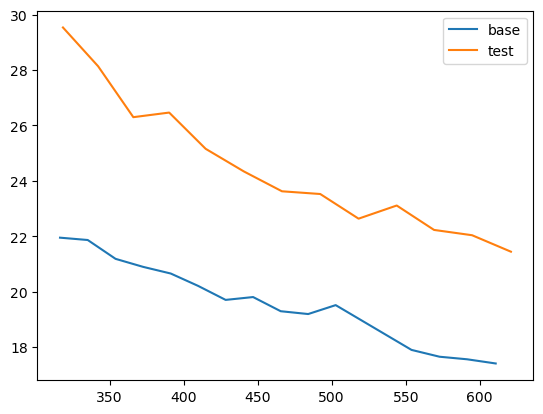

In [24]:
import pandas as pd 
b = pd.DataFrame(base_trainer.logger.log)
b["model"] = "base"
t = pd.DataFrame(test_trainer.logger.log)
t["model"] = "test"
logs_df = pd.concat([b, t])

from matplotlib import pyplot as plt
# a plot with two lines...one is where model = gelu, mode = train, steps = 250; the other is the same but with model = swiglu
train = logs_df[logs_df["mode"] == "train"]
full_steps = train[train["steps"] == 250]
full_steps = full_steps[full_steps["total_seconds"] >=300]
b = full_steps[full_steps["model"] == "base"]
t = full_steps[full_steps["model"] == "test"]
# plot ppl vs total_seconds
# clear the plot
plt.clf()
plt.plot(b["total_seconds"], b["ppl"], label="base")
plt.plot(t["total_seconds"], t["ppl"], label="test")
plt.legend()
plt.show() 